In [5]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import pickle
import os
import sys
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from scipy.optimize import minimize
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob
import time


sys.path.insert(1, '../../modules')
# hand made functions
from Rouss1 import *
from Rouss2 import *
from Rouss3D import *
from dis_flopy import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

In [2]:
#geo parameters
MNT_path = "../../data/surfaces_geoter/TOPO  (0 en mer).ASC"
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

Lx = x1-x0
Ly = y1-y0
nlay = 4
res = 300

ncol = int(Lx/res)
nrow = int(Ly/res)

delr = np.ones(ncol)*res
delc = np.ones(nrow)*res

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data

In [3]:
# load differents surfaces

top = "../../data/surfaces_geoter/TOPO (inf_0 en mer).ASC"
surfQ  = "../../data/surfaces_geoter/Mur QUAT.ASC"
surfPC = "../../data/surfaces_geoter/Mur PC.ASC"
surfPMS = "../../data/surfaces_geoter/Mur PMS.ASC"

files_surf = [top,surfQ,surfPC,surfPMS]
surfaces=[]
for file in files_surf:
    Rast = Raster.load(file)
    surfaces.append(Rast.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Rast.bands[0],
                                method="nearest"))

top = surfaces[0]
Q = surfaces[1]
PC = surfaces[2]
PMS = surfaces[3]
surfaces.insert(2,Q)

In [6]:
#domain
idomain = np.zeros([nlay,nrow,ncol])

for ilay in range(nlay):
    idomain[ilay] = active_dom(surfaces[ilay+1],grid)

In [7]:
shp_Q = "../../data/shp/entités/Q_extended.shp"
idomain[0:2]=0
gp2cellids3D(grid,gp.read_file(shp_Q),idomain,layer=0);
idomain[1] = idomain[0]

In [8]:
# pseudo active cells
for ilay in range(nlay-2):
    for irow in range(nrow):
        for icol in range(ncol):
            icell = idomain[:,irow,icol]
            if (icell[:ilay+1]==1).any() & (icell[ilay+2:]==1).any() & (icell[ilay+1] == 0):
                idomain[ilay+1,irow,icol] = - 1

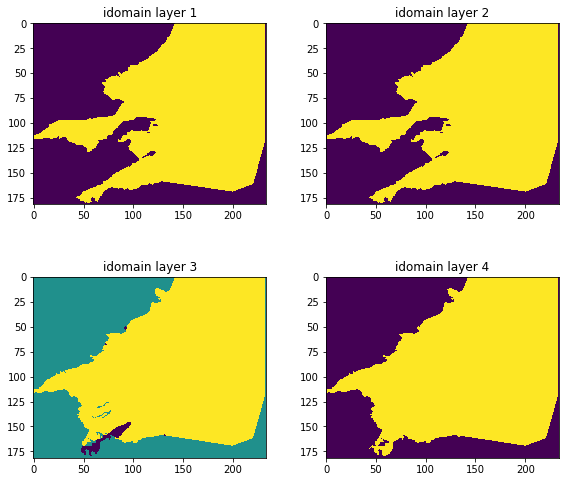

In [9]:
fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(hspace=0.4, wspace=0.1)
for i in range(1,nlay+1):
    ax = fig.add_subplot(2, 2, i)
    ax.imshow(idomain[i-1])
    plt.title("idomain layer {}".format(i))

In [10]:
#surfaces
botm = np.zeros([nlay,nrow,ncol])

bot_surf = top.copy() # a list that will contain infos about the bottom of a surface, update at each loop
for ilay in range(nlay):
   
    bot_surf[idomain[ilay] != 1] -= 0.1 # not in a the domain, 0.1 m of thickness

    if ilay == 1:
        bot_surf[idomain[ilay] == 1] = botm[0][idomain[ilay] == 1] - 2
    else:
        bot_surf[idomain[ilay] == 1] = surfaces[ilay+1][idomain[ilay] == 1] # where idomain for ilay is active --> bot_surf take the values of the surface

    botm[ilay] = bot_surf

In [11]:
MinThick(idomain,botm,top,min_ep_act=2,min_ep_inact=0.1)

In [12]:
def check_thk(top,botm):
    """
    check if a cell have a thickness <= 0 for each layer
    input : top (the top surface) and botm (botom of each layer)
    output : lst of bool (false mean everything is okay)
    """

    bol_lst=[]
    bol_lst.append(((top-botm[0])<0).any())
    for ilay in range(nlay-1):
        bol_lst.append(((botm[ilay]-botm[ilay+1])<0).any())
    return bol_lst

In [13]:
check_thk(top,botm) # everything should be False

[False, False, False, False]

In [14]:
#botm[botm<-1000]=0
#top[top<-1000]=10

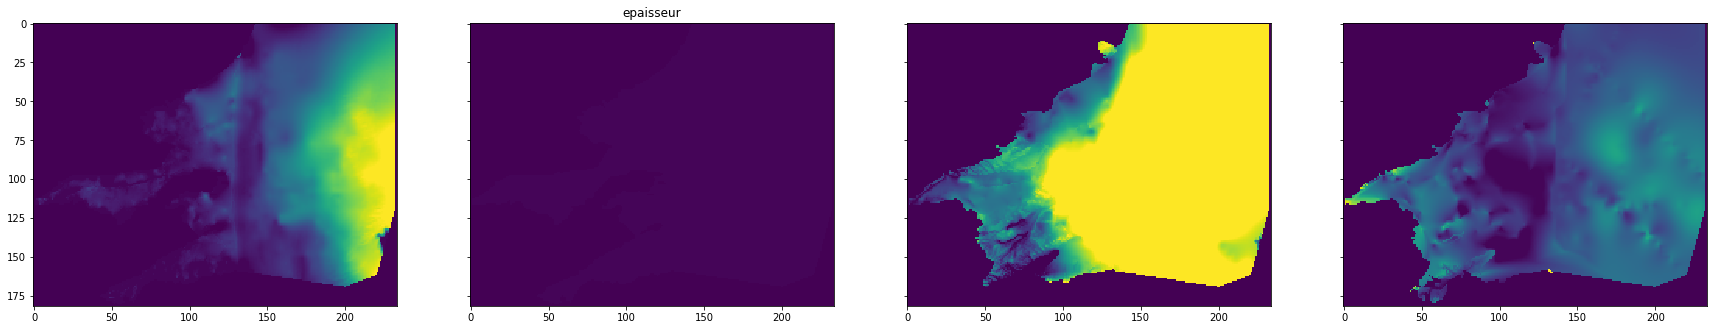

In [15]:
surf = [top,botm[0],botm[1],botm[2],botm[3]]
fig,ax = plt.subplots(1,4,sharey=True,figsize=(30,20))
i=0;l=0
for s in np.arange(len(surf)-1):
    b=ax[i].imshow(surf[s]-surf[s+1])
    b.set_clim(0,150)
    ax[1].set_title("epaisseur")
    i +=1

In [19]:
write_pickle("working/export_dis3D",[top,botm,idomain])